In [1]:
#importing libraries
import pandas as pd
import sklearn
from sklearn import svm
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from keras.utils import to_categorical 
from collections import Counter
import numpy as np
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import copy
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix,classification_report,precision_score,recall_score,roc_curve,auc

col_del=set()


In C:\Users\mohammad\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\mohammad\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\mohammad\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
Using TensorFlow backend.
C:\Users\mohammad\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mohammad\Miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWar

In [2]:
#load dataset
dftotal=pd.read_excel(r'J:\1_moh\phd\external journal\ffkc\excel\total_group_indices.xlsx')
dftotal=dftotal.loc[:,:]
X=dftotal.iloc[:,6:-1]
Y=dftotal.iloc[:,-1]

In [3]:
#Total number of features
len(X.columns)

241

In [4]:
dftotal.iloc[:,235:248].head()

,SCIndices_ShapeIndicesPh2_RMS/A_Back,SCIndices_AcqQualityIndices_EditedMeridians,SCIndices_AcqQualityIndices_ScheimpflugCoverage,SCIndices_AcqQualityIndices_PlacidoDecentration,SCIndices_AcqQualityIndices_PlacidoCoverage,SCIndices_PupilIndices_Decentration_X,SCIndices_PupilIndices_Decentration_Y,SCIndices_PupilIndices_Radius,SCIndices_LimbusIndices_LimbusCx,SCIndices_LimbusIndices_LimbusCy,SCIndices_LimbusIndices_LimbusRx,SCIndices_LimbusIndices_HVID,class
23,0.297150,100.0,99.22078,84.0,87.60654,0.210980,-0.356522,2.390980,0.259172,0.015830,6.272727,12.54545,1
19,0.170544,100.0,99.22078,89.0,94.05185,-0.208536,-0.194473,2.597479,-0.250000,0.204545,6.159090,12.31818,1
27,0.407843,100.0,99.22078,96.0,88.06818,-0.023992,0.385968,2.087091,0.253859,0.401321,6.272727,12.54545,1
18,0.161705,100.0,99.22078,88.0,85.56463,-0.183326,0.000872,1.924627,-0.476872,0.003765,6.340908,12.68182,1
22,0.413754,100.0,96.78508,91.0,79.84730,0.145260,0.452148,3.051806,0.266714,0.462942,6.340908,12.68182,1


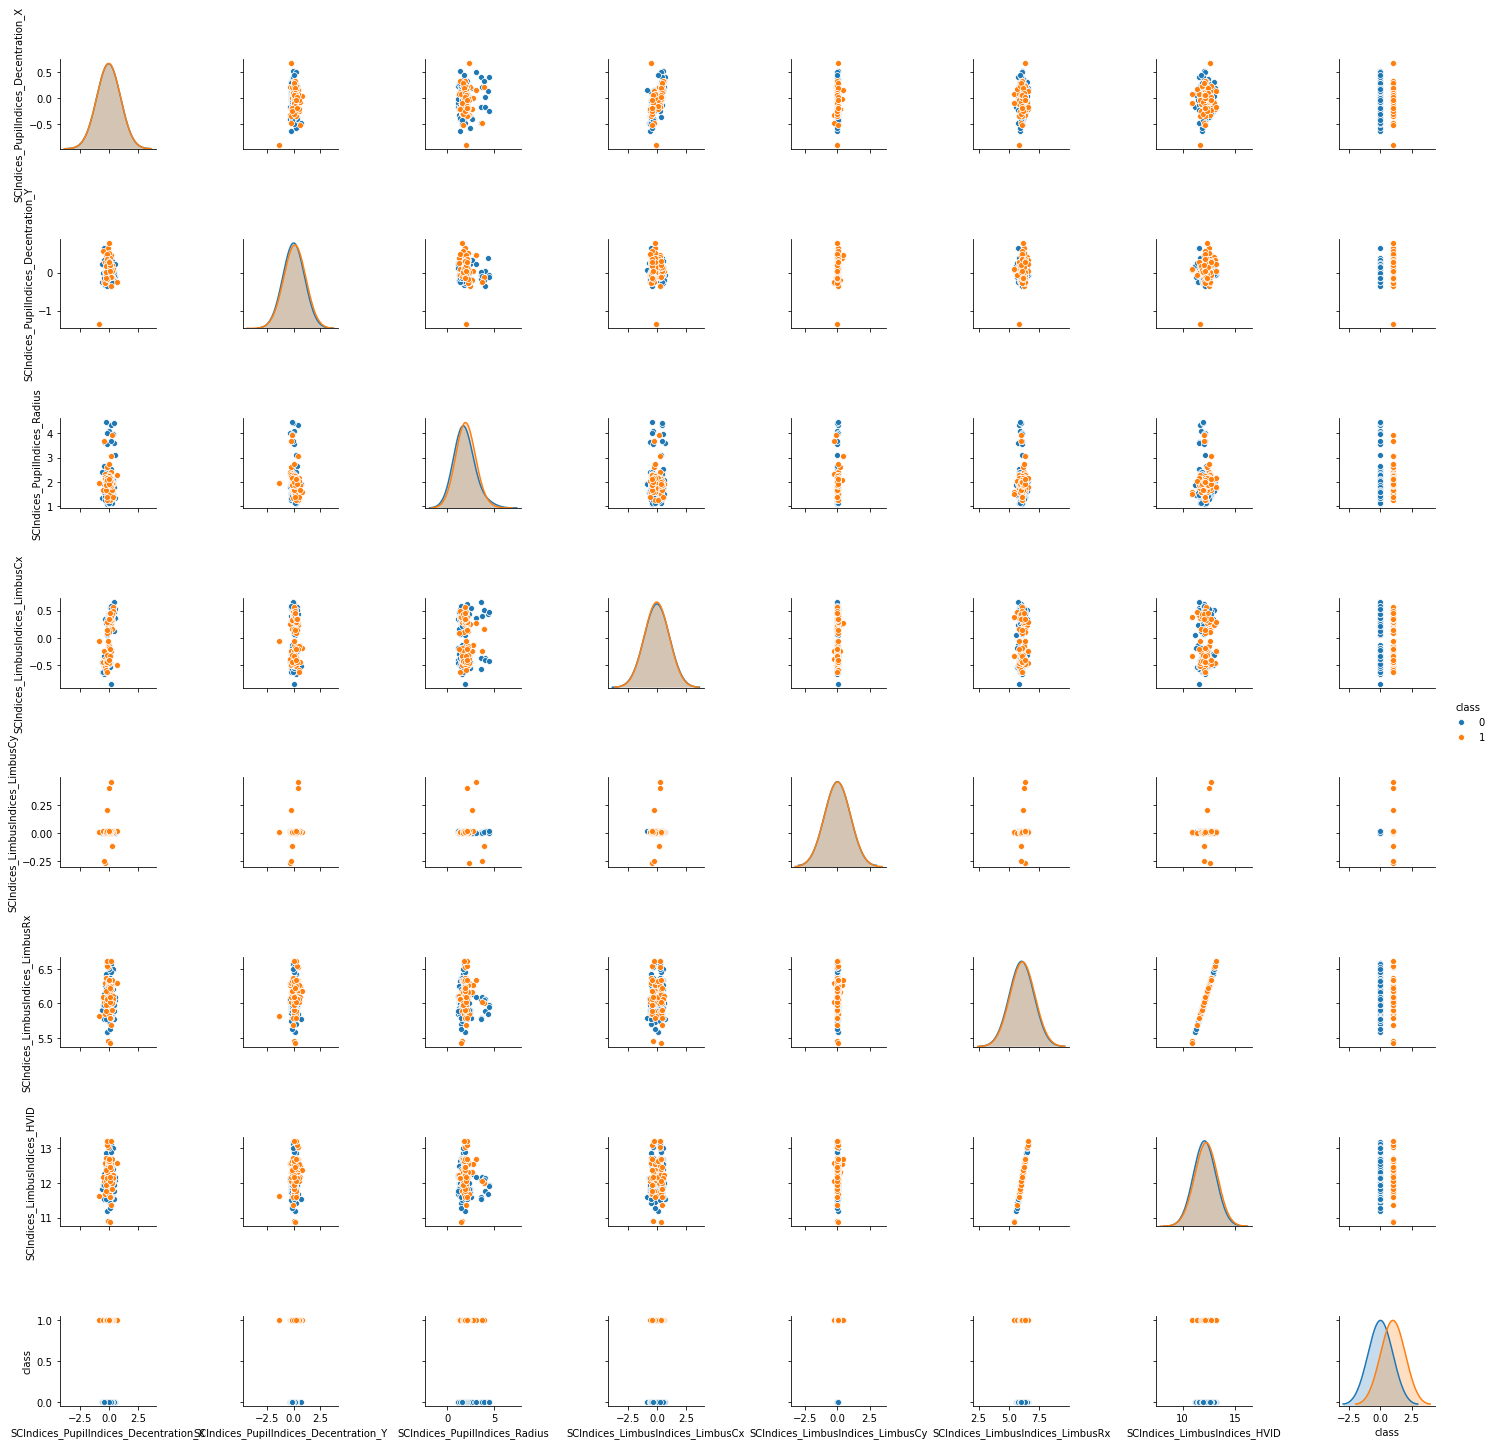

In [5]:
sn.pairplot(dftotal.iloc[:,240:248],hue='class',diag_kws={'bw': 1.0})

In [6]:
#normal distribution test
def normtest(df,col):
    from scipy.stats import kstest
    s,p1=kstest(df[df['class']==1].loc[:,col],'norm')
    s,p2=kstest(df[df['class']==0].loc[:,col],'norm')
    return p1>.05 and p2>.05

In [7]:
#variance test
def vartest(df,col):
    from scipy.stats import levene
    s,p=levene(df[df['class']==1].loc[:col],df[df['class']==0].loc[:,col])
    return p>.05

In [8]:
#T test (paretic)
def ttest(df,col,var):
    from scipy.stats import ttest_ind
    s,p=ttest_ind(df[df['class']==1].loc[:,col],
                  df[df['class']==0].loc[:,col],equal_var=var)
    return p<.05

In [9]:
#mannwhitneyu test (nonparetic)
def mwtest(df,col):
    try:
        from scipy.stats import mannwhitneyu
        s,p=mannwhitneyu(df[df['class']==1].loc[:,col],
                          df[df['class']==0].loc[:,col])
        return p<.05
    except:
        return False

In [10]:
#find statisticlly important features
important_features=[]
for c in X.columns:
    if normtest(dftotal,c):
        if ttest(dftotal,c,vartest(dftotal,c)):
            important_features.append(c)
    else:
        if mwtest(dftotal,c):
            important_features.append(c)

In [11]:
#take statisticlly important features only
X=X[important_features]

In [12]:
len(important_features)

160

In [13]:
#split dataset train and test
def splite(random):
    return  train_test_split(
    X, Y, test_size=0.10, random_state=random)

In [14]:
#calculat AUC
def calc_auc(X,y):
    auc_indices=[]
    X1=X.copy()
    for i in X:
        X1.sort_values(i,ascending=False,inplace=True)
        fpr, tpr, thresholds = metrics.roc_curve(y, X1.loc[:,i],pos_label=1)#df.loc[:,'class']
        auc_indices.append(metrics.auc(fpr,tpr))
    #print(df.columns[6:-4])
    return pd.DataFrame(auc_indices,index=X1.columns)

In [15]:
#find pair of correlated features and return the ohe of the worst AUC
def find_indices_del(cut_off,X_train,y_train):
    col_del=set()
    auc_indices=calc_auc(X_train,y_train)
    for c1,i in zip(X_train.columns,np.corrcoef(X_train,rowvar=False)):
        for c2,j in zip(X_train.columns,i):
            #print(X_train.columns)
            if np.abs(j)>cut_off:
                if c1!=c2 :
                    #print(j,"    ",c1,"    ",c2)
                    if auc_indices.loc[c1,0]>auc_indices.loc[c2,0] :
                        #print (c2)
                        col_del.add(c2)
                    else:
                        col_del.add(c1)
                elif c1==c2:
                    #print(j,"    ",c1,"    ",c2)
                    break
    return col_del

In [16]:
#delete columns
def del_columns_main(col_del):
    X.drop(col_del,axis=1,inplace=True)

In [17]:
# delete the worst one of each pair of correlated features
del_columns_main(find_indices_del(.90,X,Y))


In [18]:
#final features
len(X.columns)

74

In [19]:
#name of features
X.columns


Index(['OPD_Front_أک_6_0_Z(1_+1)', 'OPD_Front_أک_6_0_Z(3_-3)',
       'OPD_Front_أک_6_0_Z(3_+3)', 'OPD_Front_أک_6_0_Z(4_-4)',
       'OPD_Front_أک_6_0_Z(4_0)', 'OPD_Front_أک_6_0_Z(4_+2)',
       'OPD_Front_أک_6_0_Z(5_-3)', 'OPD_Front_أک_6_0_Z(5_-1)',
       'OPD_Front_أک_6_0_Z(5_+5)', 'OPD_Front_أک_6_0_Z(6_-6)',
       'OPD_Front_أک_6_0_Z(6_0)', 'OPD_Front_أک_6_0_Z(7_-7)',
       'OPD_Front_أک_6_0_Z(7_-5)', 'OPD_Front_أک_6_0_Z(7_-3)',
       'OPD_Front_أک_6_0_Cyl', 'OPD_Total_أک_6_0_Z(3_-3)',
       'OPD_Total_أک_6_0_Z(3_+3)', 'OPD_Total_أک_6_0_Z(5_-5)',
       'OPD_Total_أک_6_0_Z(5_-1)', 'OPD_Total_أک_6_0_Z(6_0)',
       'OPD_Total_أک_6_0_Z(6_+6)', 'OPD_Total_أک_6_0_Z(7_-7)',
       'OPD_Total_أک_6_0_Z(7_+5)',
       'SCIndices_KeratometricIndicesAnterior_Simk_K1Val',
       'SCIndices_KeratometricIndicesAnterior_M5mm_K1Ax',
       'SCIndices_KeratometricIndicesAnterior_Em3mm_K1Ax',
       'SCIndices_KeratometricIndicesAnterior_Em3mm_K2Ax',
       'SCIndices_KeratometricIndicesAnterio

In [20]:
X.shape


(212, 74)

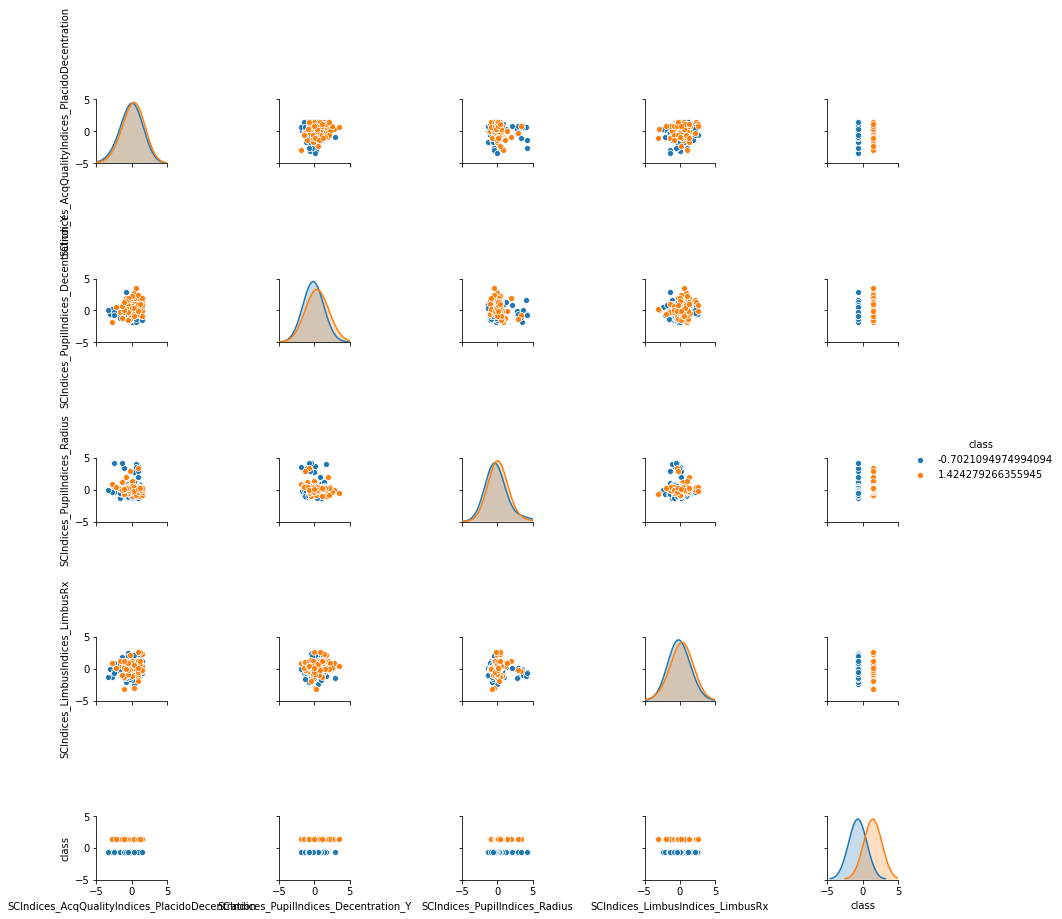

In [37]:
# pairplot 
X_y=[x for x in X.columns]
X_y.append('class')
X_y=X_y[-5:]
pp=sn.pairplot(pd.DataFrame(StandardScaler().fit_transform(dftotal.loc[:,X_y]),columns=X_y),hue='class',diag_kws={'bw': 1.3})
pp.set(xlim=(-5,5), ylim = (-5,5))
pp

In [38]:
#build models with hypertuning parameters
search_space = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 10),
    'classifier__solver' : ['liblinear']},
    
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(2,10,2))},
    
    {'classifier' : [KNeighborsClassifier()],'classifier__n_neighbors' : list(range(1,20,2)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
    
    {'classifier' : [svm.SVC()],'classifier__kernel': ['linear','rbf'], 'classifier__gamma': [.001,.01,.1,1,10,100,1000],
                     'classifier__C': [.001,.01,.1,1,10,100,1000],'classifier__probability':[True]},
    
    {'classifier' : [DecisionTreeClassifier()],'classifier__max_leaf_nodes': list(range(2, 10,2)),
            'classifier__max_depth':np.arange(2,10,2),
           'classifier__max_features':np.arange(2,10,2),
           'classifier__criterion':['gini','entropy'],
           'classifier__min_samples_split':np.arange(2,10,2)},
    
    {'classifier' : [MLPClassifier()] ,'classifier__hidden_layer_sizes': [(10,10,10), (10,20,10), (10,)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.0001,0.001,0.01,0.1],
    'classifier__learning_rate': ['constant','adaptive'],},
    
    {'classifier' : [GradientBoostingClassifier()],"classifier__loss":["deviance"],
    "classifier__learning_rate": [0.01, 0.05],
    "classifier__min_samples_split": np.linspace(0.1, 0.5,3),
    "classifier__min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "classifier__max_depth":[3,5,8],
    "classifier__max_features":["log2","sqrt"],
    "classifier__criterion": ["friedman_mse"],
    "classifier__subsample":[0.5 ,0.75, 1.0],
    "classifier__n_estimators":list(range(10, 51,20))},
    
    {'classifier' : [GaussianNB()],'classifier__var_smoothing': np.logspace(0,-4, num=5)}
    
]

pipe = Pipeline([('scaler', StandardScaler()),('PCA',PCA(.95)),('classifier', LogisticRegression())])

CLF = GridSearchCV(pipe, search_space[1], cv=5,n_jobs = -1,verbose=1,scoring='f1',)

clfs=[CLF]

In [39]:
# Train using specific model

def find_best_score2(clf,rand): 
    i=0
    print('total number of sample : ' , len(X_train), len(y_train))
    y_train_np=y_train.values.ravel()
    clf.fit(X_train, y_train_np)
    scores_para2.append(copy.deepcopy(clf))
    random2.append(rand)
    print('best model params',scores_para2[-1].cv_results_['params'][np.argmax(scores_para2[-1].cv_results_['mean_test_score'])])
    print('best model Training score',scores_para2[-1].cv_results_['mean_train_score'][np.argmax(scores_para2[-1].cv_results_['mean_test_score'])])
    print('best model Validation score',scores_para2[-1].cv_results_['mean_test_score'][np.argmax(scores_para2[-1].cv_results_['mean_test_score'])])


In [40]:
# test specific model
def find_score_test2(clf):
    score_list2.append(clf.best_estimator_.score(X_test,y_test))
    #print('scorer',clf.scorer_)
    print('best model Test score' ,score_list2[-1])
    

In [42]:

random2=[]
scaler_list2=[]
scores_para2=[]
score_list2=[]

r=77

In [43]:
#training models
i1=0
#r=np.random.randint(100)
for i in search_space:
    CLF = GridSearchCV(pipe, i, cv=5,n_jobs = -1,verbose=1,scoring='f1',return_train_score=True)
    X_train, X_test, y_train, y_test=splite(r)
    find_best_score2(CLF,r)
    find_score_test2(CLF)
    i1+=1

    

total number of sample :  190 190
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.0s finished


best model params {'classifier': LogisticRegression(C=0.3593813663804626, solver='liblinear'), 'classifier__C': 0.3593813663804626, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
best model Training score 0.9425430778371954
best model Validation score 0.8640952380952381
best model Test score 0.8636363636363636
total number of sample :  190 190
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   48.1s finished


best model params {'classifier': RandomForestClassifier(max_features=8, n_estimators=60), 'classifier__max_features': 8, 'classifier__n_estimators': 60}
best model Training score 1.0
best model Validation score 0.8620082815734991
best model Test score 0.8181818181818182
total number of sample :  190 190
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model params {'classifier': KNeighborsClassifier(n_neighbors=3), 'classifier__algorithm': 'auto', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
best model Training score 0.865071435913249
best model Validation score 0.7799787931366879
best model Test score 0.7727272727272727
total number of sample :  190 190
Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:   25.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model params {'classifier': SVC(C=100, gamma=0.001, probability=True), 'classifier__C': 100, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__probability': True}
best model Training score 0.9760780544073825
best model Validation score 0.858815734989648
best model Test score 0.9545454545454546
total number of sample :  190 190
Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:  1.6min finished


best model params {'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=8,
                       max_leaf_nodes=6, min_samples_split=4), 'classifier__criterion': 'entropy', 'classifier__max_depth': 4, 'classifier__max_features': 8, 'classifier__max_leaf_nodes': 6, 'classifier__min_samples_split': 4}
best model Training score 0.9028541279175355
best model Validation score 0.7967061923583663
best model Test score 0.8181818181818182
total number of sample :  190 190
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.8min finished


best model params {'classifier': MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 10, 10),
              learning_rate='adaptive'), 'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'adam'}
best model Training score 0.994059405940594
best model Validation score 0.8617142857142858
best model Test score 0.8636363636363636
total number of sample :  190 190
Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed:  5.3min finished


best model params {'classifier': GradientBoostingClassifier(learning_rate=0.05, max_depth=5, max_features='sqrt',
                           min_samples_leaf=0.1, min_samples_split=0.1,
                           n_estimators=50), 'classifier__criterion': 'friedman_mse', 'classifier__learning_rate': 0.05, 'classifier__loss': 'deviance', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 0.1, 'classifier__min_samples_split': 0.1, 'classifier__n_estimators': 50, 'classifier__subsample': 1.0}
best model Training score 0.969517825311943
best model Validation score 0.8424242424242424
best model Test score 0.8636363636363636
total number of sample :  190 190
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model params {'classifier': GaussianNB(var_smoothing=0.001), 'classifier__var_smoothing': 0.001}
best model Training score 0.8110160172125269
best model Validation score 0.7890450602029551
best model Test score 0.8636363636363636


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished


77

In [45]:
#summary of models results
df=pd.DataFrame(columns=['Model','Training','T_std','Validation_splits','Validation','V_std','Test_TN','Test_FN','Test_FP',
                         'Test_TP','Sensitivity','Specificity','PPV','NPV','F1-score1','F1-score0','F1-score_avg'])
for i in range(len(scores_para2)):
    pred_proba=scores_para2[i].best_estimator_.predict_proba(X_test)[:,1]
    pred=scores_para2[i].best_estimator_.predict(X_test)
    cm=confusion_matrix(y_test,pred)
    fpr, tpr, thresholds = roc_curve(y_test,pred_proba, pos_label=1)
    auc_m=auc(fpr, tpr)
    df=df.append({
        'Model':str(scores_para2[i].cv_results_['params'][np.argmax(scores_para2[i].cv_results_['mean_test_score'])]['classifier']),
        'Training':scores_para2[i].cv_results_['mean_train_score'][np.argmax(scores_para2[i].cv_results_['mean_test_score'])],
        'T_std':scores_para2[i].cv_results_['std_train_score'][np.argmax(scores_para2[i].cv_results_['mean_test_score'])],
        'Validation_splits':[
            scores_para2[i].cv_results_['split0_test_score'][np.argmax(scores_para2[i].cv_results_['mean_test_score'])],
            scores_para2[i].cv_results_['split1_test_score'][np.argmax(scores_para2[i].cv_results_['mean_test_score'])],
            scores_para2[i].cv_results_['split2_test_score'][np.argmax(scores_para2[i].cv_results_['mean_test_score'])],
            scores_para2[i].cv_results_['split3_test_score'][np.argmax(scores_para2[i].cv_results_['mean_test_score'])],
            scores_para2[i].cv_results_['split4_test_score'][np.argmax(scores_para2[i].cv_results_['mean_test_score'])]
        ],
        'Validation':scores_para2[i].cv_results_['mean_test_score'][np.argmax(scores_para2[i].cv_results_['mean_test_score'])],
        'V_std':scores_para2[i].cv_results_['std_test_score'][np.argmax(scores_para2[i].cv_results_['mean_test_score'])],
        'Test_TN':cm[0,0],
        'Test_FN':cm[1,0],
        'Test_FP':cm[0,1],
        'Test_TP':cm[1,1],
        'Sensitivity':recall_score(y_test,pred),
        'Specificity':recall_score(y_test,pred,pos_label=0),
        'PPV':precision_score(y_test,pred),
        'NPV':precision_score(y_test,pred,pos_label=0),
        'F1-score1':2*recall_score(y_test,pred)*precision_score(y_test,pred)/(recall_score(y_test,pred)+precision_score(y_test,pred)),
        'F1-score0':2*recall_score(y_test,pred,pos_label=0)*precision_score(y_test,pred,pos_label=0)/
        (recall_score(y_test,pred,pos_label=0)+precision_score(y_test,pred,pos_label=0)),
        'F1-score_avg':score_list2[i],
        'AUC':auc_m
    },ignore_index=True)

In [46]:
#best model AUC
scores_para2[3].best_params_

{'classifier': SVC(C=100, gamma=0.001, probability=True),
 'classifier__C': 100,
 'classifier__gamma': 0.001,
 'classifier__kernel': 'rbf',
 'classifier__probability': True}

In [47]:
# sort according to validation results
df.sort_values(by='Validation',ascending=False)

,Model,Training,T_std,Validation_splits,Validation,V_std,Test_TN,Test_FN,Test_FP,Test_TP,Sensitivity,Specificity,PPV,NPV,F1-score1,F1-score0,F1-score_avg,AUC
0,"LogisticRegression(C=0.3593813663804626, solve...",0.942543,0.023952,"[0.761904761904762, 0.8799999999999999, 1.0, 0...",0.864095,0.092057,16,3,0,3,0.500000,1.0000,1.00,0.842105,0.666667,0.914286,0.863636,0.875000
1,"RandomForestClassifier(max_features=8, n_estim...",1.000000,0.000000,"[0.761904761904762, 0.9166666666666666, 1.0, 0...",0.862008,0.091791,15,3,1,3,0.500000,0.9375,0.75,0.833333,0.600000,0.882353,0.818182,0.781250
5,"MLPClassifier(activation='tanh', hidden_layer_...",0.994059,0.004850,"[0.8333333333333333, 0.8333333333333333, 1.0, ...",0.861714,0.078778,15,2,1,4,0.666667,0.9375,0.80,0.882353,0.727273,0.909091,0.863636,0.937500
3,"SVC(C=100, gamma=0.001, probability=True)",0.976078,0.013645,"[0.8695652173913044, 0.7826086956521738, 1.0, ...",0.858816,0.084494,16,1,0,5,0.833333,1.0000,1.00,0.941176,0.909091,0.969697,0.954545,0.947917
6,"GradientBoostingClassifier(learning_rate=0.05,...",0.969518,0.016512,"[0.8181818181818181, 0.7500000000000001, 1.0, ...",0.842424,0.102696,16,3,0,3,0.500000,1.0000,1.00,0.842105,0.666667,0.914286,0.863636,0.833333
4,"DecisionTreeClassifier(criterion='entropy', ma...",0.902854,0.015008,"[0.6956521739130435, 0.7272727272727274, 1.0, ...",0.796706,0.111825,15,3,1,3,0.500000,0.9375,0.75,0.833333,0.600000,0.882353,0.818182,0.802083
7,GaussianNB(var_smoothing=0.001),0.811016,0.021614,"[0.7272727272727274, 0.7692307692307693, 0.960...",0.789045,0.112131,16,3,0,3,0.500000,1.0000,1.00,0.842105,0.666667,0.914286,0.863636,0.875000
2,KNeighborsClassifier(n_neighbors=3),0.865071,0.022491,"[0.631578947368421, 0.9166666666666666, 0.9230...",0.779979,0.121942,14,3,2,3,0.500000,0.8750,0.60,0.823529,0.545455,0.848485,0.772727,0.750000


In [48]:
#statistical tests
def normtest_m(s1,s2):
    from scipy.stats import kstest
    s,p1=kstest(s1,'norm')
    s,p2=kstest(s2,'norm')
    return p1>.05 and p2>.05
#variance test
def vartest_m(s1,s2):
    from scipy.stats import levene
    s,p=levene(s1,s2)
    return p>.05
#T test (paretic)
def ttest_m(s1,s2,var):
    from scipy.stats import ttest_ind
    s,p=ttest_ind(s1,
                  s2,equal_var=var)
    return p<.05
#mannwhitneyu test (nonparetic)
def mwtest_m(s1,s2):
        from scipy.stats import mannwhitneyu
        s,p=mannwhitneyu(s1,
                          s2)
        return p<.05
def kruskaltest_m(s1):
        from scipy.stats import kruskal
        s,p=kruskal(*s1)
        return p<.05

In [49]:
#compare models mannwhitneyu(pairs)
model_pairs=[]
for index1 in df.index:
    for index2 in df.index[index1+1:]:
        if normtest_m(df.loc[index1,'Validation_splits'],df.loc[index2,'Validation_splits']):
            if ttest_m(df.loc[index1,'Validation_splits'],df.loc[index2,'Validation_splits'],
                     vartest_m(df.loc[index1,'Validation_splits'],df.loc[index2,'Validation_splits'])):
                model_pairs.append([index1,index2,'T test','Sig'])
            else:
                model_pairs.append([index1,index2,'T test','Not Sig'])
        else:
            if mwtest_m(df.loc[index1,'Validation_splits'],df.loc[index2,'Validation_splits']):
                model_pairs.append([index1,index2,'MW test','Sig'])
            else:
                model_pairs.append([index1,index2,'MW test','Not Sig'])
model_pairs                

[[0, 1, 'MW test', 'Not Sig'],
 [0, 2, 'MW test', 'Not Sig'],
 [0, 3, 'MW test', 'Not Sig'],
 [0, 4, 'MW test', 'Not Sig'],
 [0, 5, 'MW test', 'Not Sig'],
 [0, 6, 'MW test', 'Not Sig'],
 [0, 7, 'MW test', 'Not Sig'],
 [1, 2, 'MW test', 'Not Sig'],
 [1, 3, 'MW test', 'Not Sig'],
 [1, 4, 'MW test', 'Not Sig'],
 [1, 5, 'MW test', 'Not Sig'],
 [1, 6, 'MW test', 'Not Sig'],
 [1, 7, 'MW test', 'Not Sig'],
 [2, 3, 'MW test', 'Not Sig'],
 [2, 4, 'MW test', 'Not Sig'],
 [2, 5, 'MW test', 'Not Sig'],
 [2, 6, 'MW test', 'Not Sig'],
 [2, 7, 'MW test', 'Not Sig'],
 [3, 4, 'MW test', 'Not Sig'],
 [3, 5, 'MW test', 'Not Sig'],
 [3, 6, 'MW test', 'Not Sig'],
 [3, 7, 'MW test', 'Not Sig'],
 [4, 5, 'MW test', 'Not Sig'],
 [4, 6, 'MW test', 'Not Sig'],
 [4, 7, 'MW test', 'Not Sig'],
 [5, 6, 'MW test', 'Not Sig'],
 [5, 7, 'MW test', 'Not Sig'],
 [6, 7, 'MW test', 'Not Sig']]

In [50]:
#compare models kruskal test
kruskaltest_m(list(df.loc[:,'Validation_splits']))

False

In [51]:
#ROC Curves drawing function
def draw_ROC(models,y_true):
    ROCS=[]
    colors=['tab:orange','tab:green','tab:red','tab:purple',
            'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - ROC Curves')
    for model in models:
        y_pred=model.best_estimator_.predict_proba(X_test)[:,1]
        model_name=str(model.best_estimator_.get_params()['steps'][2][1])
        model_name=model_name[:model_name.find('(')]
        false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_true, y_pred,pos_label=1)
        auc_m=auc(false_positive_rate1, true_positive_rate1)
        ROCS.append([auc_m,false_positive_rate1, true_positive_rate1, threshold1,model_name])
    ROCS.sort(key=lambda x:x[0])
    for roc,color in zip(ROCS,colors):
        plt.plot(roc[1], roc[2],color=color,dashes=[6,2], label=roc[4]+ ' AUC:' + '{0:.3f}'.format(roc[0]))
        
    for a,b,c in zip(ROCS[-1][1],ROCS[-1][2],ROCS[-1][3]):
        plt.annotate('{0:.3f}'.format(c),xy=(a-.05,b+.02))
        #print(-a+b,"   ",c)
    plt.plot([0, 1], ls="--")
#     plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

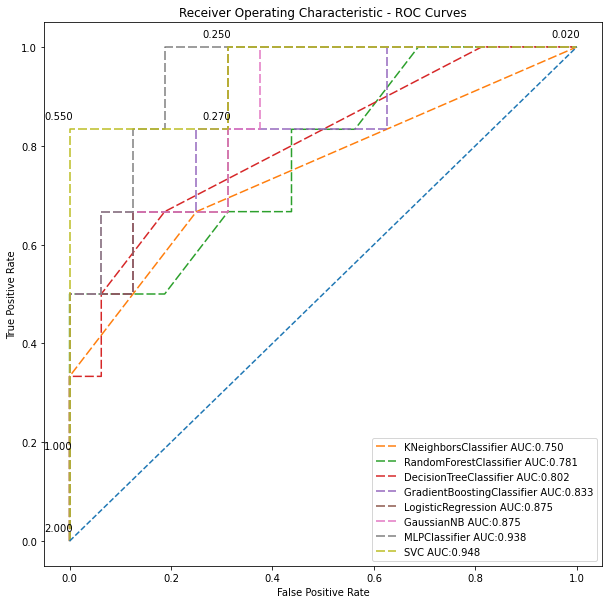

In [52]:
#ROC Curves of all models
draw_ROC(scores_para2,y_test)

In [57]:
#cut off point .25
pred=scores_para2[3].best_estimator_.predict_proba(X_test)[:,1]>=.25
cm=confusion_matrix(y_test,pred)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.92      0.69      0.79        16
           1       0.50      0.83      0.62         6

    accuracy                           0.73        22
   macro avg       0.71      0.76      0.71        22
weighted avg       0.80      0.73      0.74        22



In [58]:
#cut off point .55
pred=scores_para2[3].best_estimator_.predict_proba(X_test)[:,1]>=.55
cm=confusion_matrix(y_test,pred)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      0.67      0.80         6

    accuracy                           0.91        22
   macro avg       0.94      0.83      0.87        22
weighted avg       0.92      0.91      0.90        22



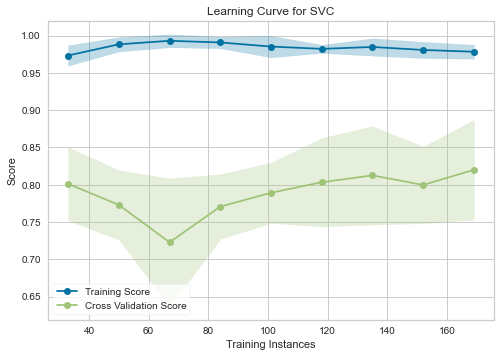

LearningCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000201A877F4A8>,
              cv=5,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('PCA', PCA(n_components=0.95)),
                                        ('classifier',
                                         SVC(C=100, gamma=0.001,
                                             probability=True))]),
              scoring='f1',
              train_sizes=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


In [59]:
#learning curve to estimate the need of increasing dataset size
from yellowbrick.model_selection import learning_curve
train_sizes=np.linspace(0.1, 1, 10)
final_model=scores_para2[3].best_estimator_
print(learning_curve(final_model, X,Y, cv=5, scoring='f1',train_sizes=train_sizes))